# Лабораторная работа 3
Классификация в sklearn. Метрики классификации

Выполнила: Кривоконева Екатерина, группа 6133

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
import sys  
warnings.simplefilter("ignore")

## Загрузка датасета

In [2]:
data = pd.read_csv('data/googleplaystore.csv')
data.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


`googleplaystore.csv` содержит подробную информацию о приложениях в Google Play. 

Числовые признаки:

- Rating - Общий пользовательский рейтинг приложения 
- Reviews - Количество отзывов пользователей о приложении 

Категориальные признаки:

- App - Название приложения
- Category - Категория, к которой относится приложение
- Size - Размер приложения 
- Installs - Количество загрузок/установок приложения пользователями 
- Type - Платный или бесплатный
- Price - Стоимость приложения 
- Content - Возрастная группа, на которую ориентировано приложение
- Genres - Жанр приложения (помимо основной категории)

Ссылка на датасет: https://www.kaggle.com/lava18/google-play-store-apps



### Предобработка данных

Заменим Nan в столбце Rating средним значением по этому признаку:

In [3]:
data.Rating = data.Rating.fillna(data.Rating.mean())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          10841 non-null  float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Далее добавим еще немного числовых признаков. 

Удалим строки которые содержат ошибочные значения: 

In [4]:
idx_list = []

for i in range(data.shape[0]):
  if not data.iloc[i, data.columns.get_loc('Reviews')].isdigit():
    idx_list.append(i)

data = data.drop(data.index[idx_list])
data.Reviews = data.Reviews.astype('int')

Уберем знак доллара и оставим только цену в долларах:

In [5]:
data.Price = data.Price.apply(lambda x: x.replace('$',''))
data.Price = data.Price.astype('float32')

Возьмем в качестве значений столбца Installs числа без плюса:

In [6]:
data.Installs = data.Installs.apply(lambda x: x.split('+')[0])
data.Installs = data.Installs.apply(lambda x: x.replace(',',''))
data.Installs = data.Installs.astype('int')

Превратим значения из Size в числа с плавающей точкой:

In [7]:
modified_size = []
for item in list(data.Size):
    if "M" in item:
        modified_size.append(float(item.upper().split("M")[0]))
    elif "K" in item:
        modified_size.append(float(item.upper().split("K")[0]) / 0.001)
    else:
        modified_size.append(0.0)
data['Size'] = modified_size

data.Size = data.Size.astype('float32')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float32
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  float32
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float32(2), float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [9]:
data.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [10]:
data = data.dropna(subset = ['Current Ver', 'Android Ver', 'Type'])

## Многоклассовая классификация

Преобразуем категориальные признаки в числовые:

In [11]:
data['App'] = data['App'].astype('category').cat.codes
data['Category'] = data['Category'].astype('category').cat.codes
data['Type'] = data['Type'].astype('category').cat.codes
data['Content Rating'] = data['Content Rating'].astype('category').cat.codes
data['Genres'] = data['Genres'].astype('category').cat.codes
data['Last Updated'] = data['Last Updated'].astype('category').cat.codes
data['Current Ver'] = data['Current Ver'].astype('category').cat.codes
data['Android Ver'] = data['Android Ver'].astype('category').cat.codes

Балансировка целевой переменной (Installs):

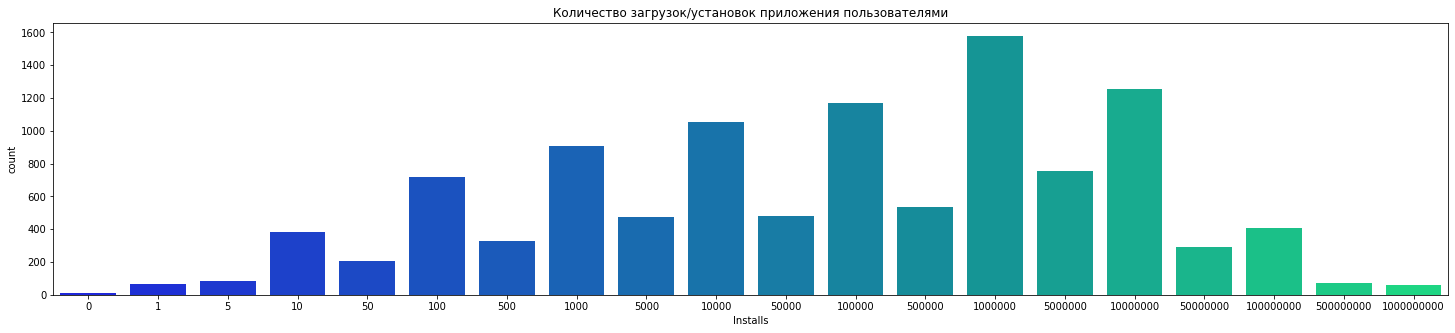

In [12]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(data['Installs'], palette='winter')
ax.set(title='Количество загрузок/установок приложения пользователями')
plt.show()

Посмотрим корреляцию между признаками:

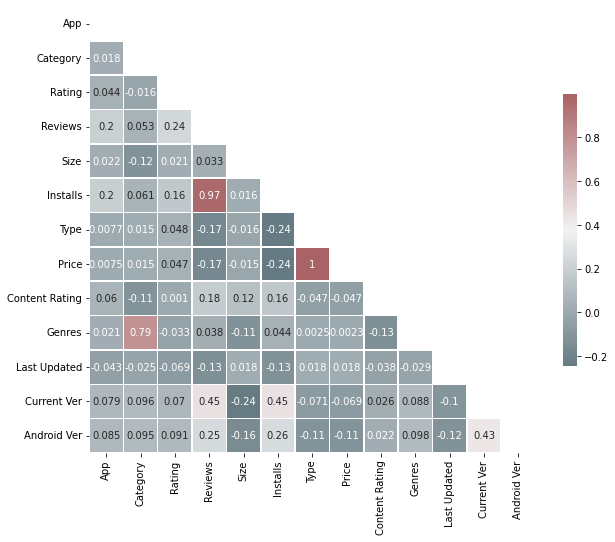

In [13]:
corr = data.corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, 30, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True
            )
plt.show()

Таким образом, целевая переменная сильно коррелирует с признаком "Reviews" и умеренно с "Current Ver".

In [14]:
# параметры для дерева решений
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )

# поиск лучших гиперпараметров
def do_grid_search(model, params, x_train, y_train, x_test, refit='accuracy'):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    grid_search = GridSearchCV(model, params, scoring=['accuracy'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)

# вывод результата
def print_result(y_test, pred=None):
  print("результат классификации: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  fig, ax = plt.subplots(figsize=(10, 7))
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)
  plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Installs', axis=1), data['Installs'], test_size=0.6, random_state=42)

### Классификация без настройки параметров

In [16]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       0.22      0.29      0.25         7
           1       0.12      0.10      0.11        41
           5       0.08      0.10      0.09        39
          10       0.29      0.26      0.28       235
          50       0.11      0.12      0.11       119
         100       0.41      0.36      0.38       437
         500       0.13      0.15      0.14       194
        1000       0.43      0.43      0.43       536
        5000       0.27      0.30      0.28       288
       10000       0.51      0.49      0.50       624
       50000       0.22      0.24      0.23       267
      100000       0.55      0.53      0.54       696
      500000       0.28      0.28      0.28       321
     1000000       0.62      0.58      0.60       959
     5000000       0.40      0.45      0.42       472
    10000000       0.65      0.66      0.66       777
    50000000       0.54      0.49      0.51       166


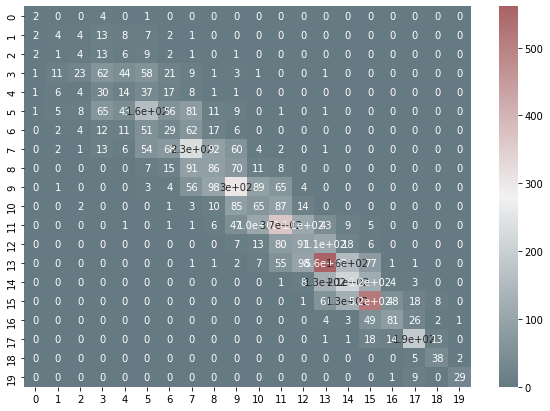

Средняя точность без настройки гиперпараметров:  0.4634057073447502


In [17]:
print_result(y_test=y_test, pred=predictions)
score = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность без настройки гиперпараметров: ', np.mean(score))

### Классификация с настройкой гиперпараметров

In [18]:
do_grid_search(model=dtree, params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best params for accuracy
{'max_depth': 5.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}


результат классификации: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        39
          10       0.36      0.78      0.49       235
          50       0.00      0.00      0.00       119
         100       0.43      0.50      0.46       437
         500       0.00      0.00      0.00       194
        1000       0.45      0.71      0.55       536
        5000       0.00      0.00      0.00       288
       10000       0.57      0.59      0.58       624
       50000       0.24      0.13      0.17       267
      100000       0.54      0.72      0.62       696
      500000       0.31      0.10      0.15       321
     1000000       0.59      0.77      0.67       959
     5000000       0.41      0.35      0.38       472
    10000000       0.68      0.67      0.68       777
    50000000       0.43      0.37      0.40       166


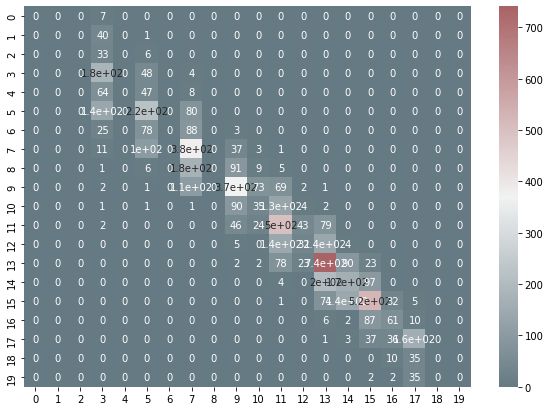

Средняя точность с настройкой гиперпараметров:  0.504274515131416


In [19]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=5.0, min_samples_leaf=0.01, min_samples_split=0.01)
print_result(y_test=y_test, pred=dtree_grid.fit(X_train, y_train).predict(X_test))
score = cross_val_score(dtree_grid, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров: ', np.mean(score))

С настройкой гиперпараметров точность увеличилась.

### Графики accuracy для train set и test_set для разных значений гиперпараметра

In [20]:
max_depth = np.linspace(1, 30, 30, endpoint=True)
accuracy_result = []
cv_result = []
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train, y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

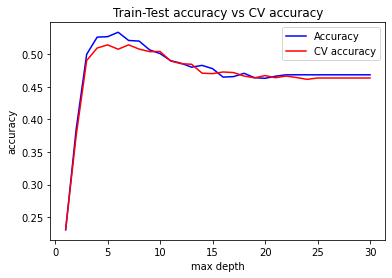

In [21]:
plt.plot(max_depth, accuracy_result, color='b', label='Accuracy')
plt.plot(max_depth, cv_result, color='r', label='CV accuracy')
plt.title('Train-Test accuracy vs CV accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
accuracy_result_train, accuracy_result_test = [], []
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train, y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

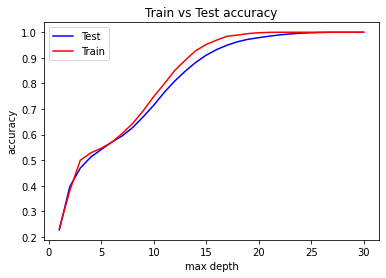

In [23]:
plt.plot(max_depth, accuracy_result_test, color='b', label='Test')
plt.plot(max_depth, accuracy_result_train, color='r', label='Train')
plt.title('Train vs Test accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

### Нормализация признаков

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       0.18      0.29      0.22         7
           1       0.12      0.10      0.11        41
           5       0.08      0.10      0.09        39
          10       0.29      0.26      0.27       235
          50       0.11      0.13      0.12       119
         100       0.41      0.36      0.38       437
         500       0.14      0.15      0.14       194
        1000       0.43      0.43      0.43       536
        5000       0.27      0.30      0.28       288
       10000       0.51      0.49      0.50       624
       50000       0.22      0.25      0.23       267
      100000       0.55      0.53      0.54       696
      500000       0.28      0.28      0.28       321
     1000000       0.62      0.59      0.60       959
     5000000       0.41      0.45      0.43       472
    10000000       0.65      0.66      0.66       777
    50000000       0.54      0.49      0.51       166


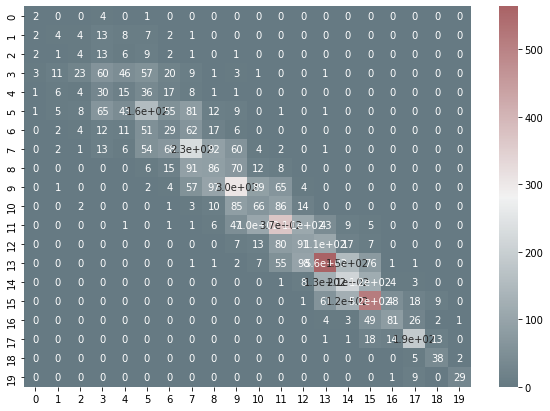

Средняя точность с масштабируемыми признаками:  0.46225150568310464


In [25]:
dtree_scaled = DecisionTreeClassifier(random_state=42)
print_result(y_test=y_test, pred=dtree_scaled.fit(X_train_scaled, y_train).predict(X_test_scaled))
score = cross_val_score(dtree_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

print('Средняя точность с масштабируемыми признаками: ', np.mean(score))

С нормализацией признаков точность обучения модели самая низкая.

## Бинарная классификация

Датасет: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### Описание данных

Числовые признаки:
- id - Unique id
- age - Age
- hypertension - Hypertension binary feature
- heart_disease - Heart disease binary feature
- avg_glucose_level - Average glucose level in blood
- bmi - Body Mass Index
- stroke - Stroke event

Категориальные признаки:
- gender - Gender
- work_type - Work type of the patient
- Residence_type - Residence type of the patient
- smoking_status - Smoking status of the patient
- ever_married - Has the patient ever been married?



In [26]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Работа с пропущенными значениями

In [27]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [28]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age', 'gender', 'bmi']].copy()
X.gender = X.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [29]:
print('Missing values: ', sum(df.isnull().sum()))

Missing values:  0


Преобразование категориальных признаков в числовые:

In [30]:
df.gender = df.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)
df.Residence_type = df.Residence_type.replace({'Urban':0, 'Rural':1}).astype(np.uint8)
df.ever_married = df.ever_married.replace(['No', 'Yes'], [0, 1])
df['smoking_status'] = df['smoking_status'].astype('category').cat.codes
df['work_type'] = df['work_type'].astype('category').cat.codes

In [31]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,2,0,228.69,36.600000,1,1
1,51676,1,61.0,0,0,1,3,1,202.21,29.879487,2,1
2,31112,0,80.0,0,1,1,2,1,105.92,32.500000,2,1
3,60182,1,49.0,0,0,1,2,0,171.23,34.400000,3,1
4,1665,1,79.0,1,0,1,3,1,174.12,24.000000,2,1


Целевая переменная: "stroke". Посмотрим ее распределение:

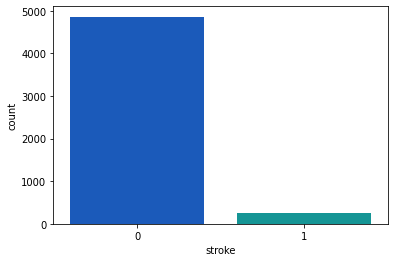

In [32]:
sns.countplot(df.stroke, palette='winter')
plt.show()

Видно, что данные сильно несбаланисрованы. Создадим новый train датасет методом upsampling:

In [33]:
train_data = df.sample(frac=0.6, random_state=25)

In [34]:
# во сколько раз одних признаков больше других
rat = len(train_data.loc[train_data['stroke']==0])//len(train_data.loc[train_data['stroke']==1])
rat

17

In [35]:
df_1 = train_data.loc[train_data['stroke']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([train_data.loc[train_data['stroke']==0], df_1]).sample(frac=1)

In [36]:
test_data = df.drop(labels=train_data.index)
X_train = train_n[train_n.columns.difference(['stroke'])]
y_train = train_n['stroke']
X_test = test_data[test_data.columns.difference(['stroke'])]
y_test = test_data['stroke']

### Классификация без настройки гиперпараметров

результат классификации: 
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      1957
           1       0.13      0.80      0.22        87

    accuracy                           0.76      2044
   macro avg       0.56      0.78      0.54      2044
weighted avg       0.95      0.76      0.83      2044

Матрица ошибок: 
 [[1490  467]
 [  17   70]] 



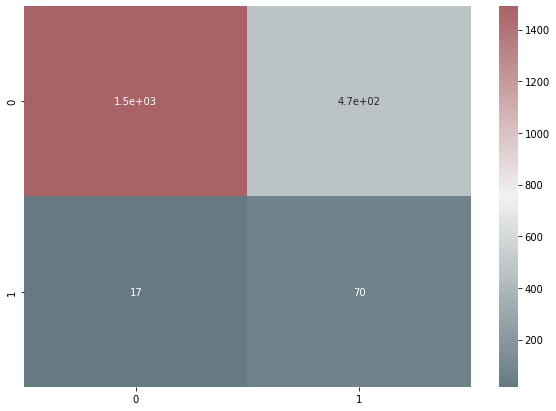

In [37]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train ,y_train)
lr_pred = lr.predict(X_test)

print_result(y_test=y_test, pred=lr_pred)

In [38]:
scores = cross_val_score(lr, X_train, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7658131113839655


### Нормализация признаков

результат классификации: 
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      1957
           1       0.13      0.80      0.22        87

    accuracy                           0.76      2044
   macro avg       0.56      0.78      0.54      2044
weighted avg       0.95      0.76      0.83      2044

Матрица ошибок: 
 [[1491  466]
 [  17   70]] 



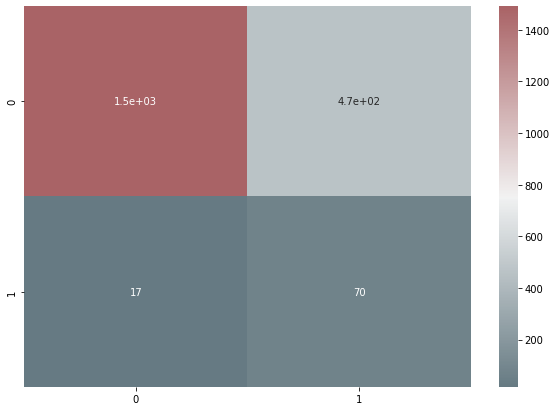

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train_scaled ,y_train)
lr_pred = lr.predict(X_test_scaled)

print_result(y_test=y_test, pred=lr_pred)

In [40]:
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7658131113839655


Использование масштабирования признаков позволило немного увеличить точность. 

### Настройка гиперпараметров

In [41]:
params={"C":[*np.arange(0,1, 0.01)], "penalty":["none", "l2"]}
do_grid_search(
    model=lr, 
    params=params, 
    x_train=X_train, 
    y_train=y_train, 
    x_test=X_test
    )

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params for accuracy
{'C': 0.01, 'penalty': 'l2'}


результат классификации: 
               precision    recall  f1-score   support

           0       0.98      0.69      0.81      1957
           1       0.10      0.76      0.18        87

    accuracy                           0.70      2044
   macro avg       0.54      0.73      0.49      2044
weighted avg       0.95      0.70      0.79      2044

Матрица ошибок: 
 [[1357  600]
 [  21   66]] 



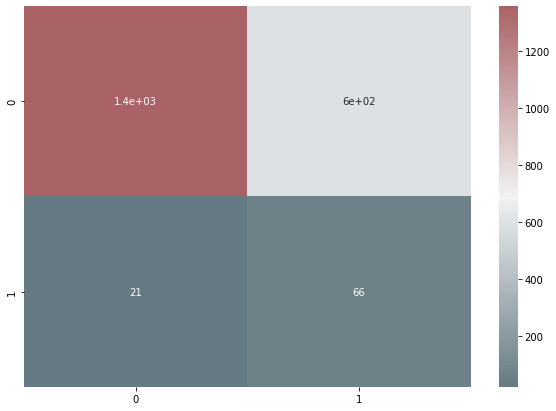

Средняя точность с настройкой гиперпараметров:  0.7131424706238889


In [43]:
lr = LogisticRegression(C=.01, penalty="l2")
lr.fit(X_train,y_train)
print_result(y_test=y_test, pred=lr.fit(X_train, y_train).predict(X_test))
score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров: ', np.mean(score))

С настройкой гиперпараметров значение точности оказалось немного меньше.